In [8]:
import pandas as pd
import harboropt_lp_storage
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
import seaborn as sns
%reload_ext autoreload
%autoreload 2

In [9]:
runs = []

lp = harboropt_lp_storage.DOSCOE(discount_rate = 0.06, storage_life = 30, gas_fuel_cost = 4)
lp.solve()
runs.append(lp)

Solver found optimal solution.


### Results for lp_storage

In [17]:
resource_gen_dict = {}

for resource in lp.disp.index:
    gen_list = []
    for i_gen in lp.disp_gen[str(resource)]:
        gen = i_gen.solution_value()
        gen_list.append(gen)
    resource_gen_dict[resource]=gen_list

for resource in lp.nondisp.index:
    profiles = pd.read_csv('data/doscoe_profiles.csv')
    profile_max = max(profiles[resource])
    profile = profiles[resource] / profile_max
    
    capacity = lp.capacity_vars[resource].solution_value()
    
    gen_list = profile * capacity
    resource_gen_dict[resource]=gen_list
    
# for resource in lp.storage.index:
#     gen_list = storage_results[resource]['hourly_net_source']
#     resource_gen_dict[resource]=gen_list
    
for resource in lp.storage.index:
    storage_hourly_charge = []
    for i,var in enumerate(lp.storage_charge_vars[resource]):
        charge = var.solution_value()
        storage_hourly_charge.append(-charge)
    
for resource in lp.storage.index:
    storage_hourly_discharge = []
    for i,var in enumerate(lp.storage_discharge_vars[resource]):
        discharge = var.solution_value()
        storage_hourly_discharge.append(discharge)

    resource_gen_dict['STORAGE_DISCHARGE']=storage_hourly_discharge

In [18]:
all_resources = list(resource_gen_dict.keys())

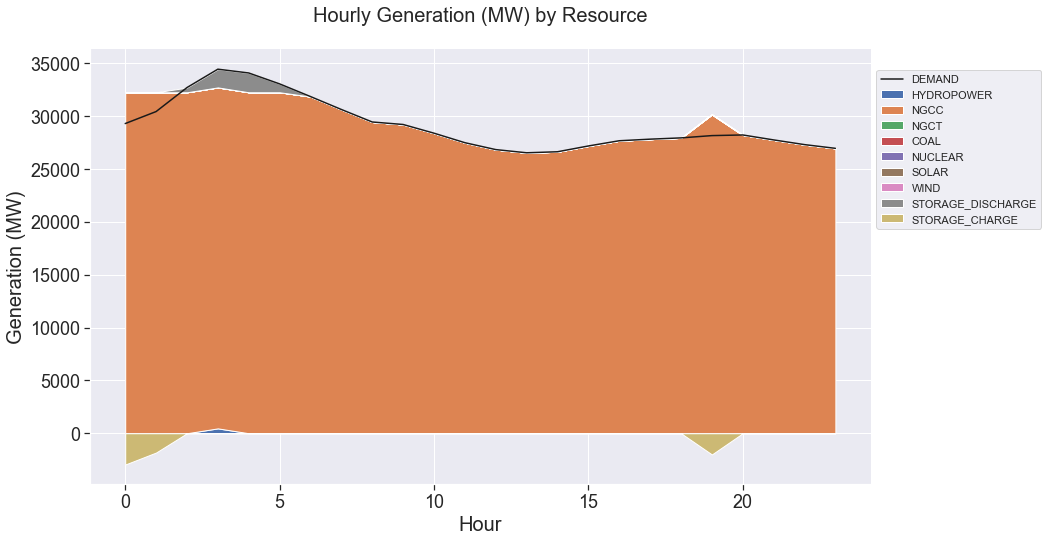

In [26]:
start_hour = 0
end_hour = 24


fig, ax = plt.subplots()
# for resource in all_resources:
#     gen_line = resource_gen_dict[resource]
#     plt.plot(profiles.index[start_hour:end_hour], gen_line[start_hour:end_hour], label = str(resource))#, color=resource_colors[resource]) 

#Plot generation lines for each resource as stacked area chart.
lst = list(resource_gen_dict.values())
lines = [item[start_hour:end_hour] for item in lst]
labels = list(resource_gen_dict.keys())
plt.stackplot(profiles.index[start_hour:end_hour], lines, labels = labels)
plt.stackplot(profiles.index[start_hour:end_hour], storage_hourly_charge[start_hour:end_hour], labels = ['STORAGE_CHARGE',])

#Plot demand.
plt.plot(profiles.index[start_hour:end_hour], profiles.DEMAND[start_hour:end_hour], label = 'DEMAND', color = 'k')

sns.set()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.77))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Hour', fontsize = 20)
ax.set_ylabel('Generation (MW)', fontsize = 20)
ax.set_title('Hourly Generation (MW) by Resource',fontsize = 20).set_position([.5, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig.set_size_inches(14, 8)